**Named Entity Recognition using BiLSTM network.**

In [ ]:
import sys
print(sys.version)

3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Loading the dataset**

In [ ]:
import pandas as pd 
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/nlp_project/datasest/ner_dataset.csv',encoding='latin1')

In [ ]:
data.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


###Explore the dataset

In [ ]:
data.describe() 

,Sentence #,Word,POS,Tag
count,47959,1048575,1048575,1048575
unique,47959,35178,42,17
top,Sentence: 1,the,NN,O
freq,1,52573,145807,887908


In [ ]:
print(data) 

          Sentence #           Word  POS Tag
0        Sentence: 1      Thousands  NNS   O
1                NaN             of   IN   O
2                NaN  demonstrators  NNS   O
3                NaN           have  VBP   O
4                NaN        marched  VBN   O
...              ...            ...  ...  ..
1048570          NaN           they  PRP   O
1048571          NaN      responded  VBD   O
1048572          NaN             to   TO   O
1048573          NaN            the   DT   O
1048574          NaN         attack   NN   O

[1048575 rows x 4 columns]


The dataset contains 4 columns (features) and 1048575 rows. As seen in the "sentence" column contain a lot of Null (NaN) values. In order to ensure biased results, we need to get rid of Null values. We calculate the number of words and Null values across the datframe. 

In [ ]:
# check how many rows have NaNs
data.isnull().sum()

Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

**Filling NaN values**v :
In order to get rid of NaN cells, we use ffill method. 
This method will impute null values with its preceeding values. 

In [ ]:
data = data.fillna(method='ffill')
data.head(50)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [ ]:
#check if we still have any NaN values
#the objects will show number of null values if there are any
data.isnull().sum()

Sentence #    0
Word          0
POS           0
Tag           0
dtype: int64

In order to get deeper ideas of dataset, we try to see the number of words for each labels/ tags. 

In [ ]:
#dataset grouped by tags
data.groupby('Tag').size().reset_index(name='counts')


,Tag,counts
0,B-art,402
1,B-eve,308
2,B-geo,37644
3,B-gpe,15870
4,B-nat,201
5,B-org,20143
6,B-per,16990
7,B-tim,20333
8,I-art,297
9,I-eve,253


Now we extract the words and create a list of words from all sentences and corresponding tags for sentences. 

In [ ]:
word_list = list(set(data['Word'].values))
number_of_words = len(word_list)

In [ ]:
list_of_tags = list(set(data['Tag'].values))#iob2 tags 
number_of_tags = len(list_of_tags)

In [ ]:
number_of_words, number_of_tags

(35178, 17)

## Retrieve Sentences and it's Tags

In [ ]:
class retriever(object):
    def __init__(self, data):
        self.n_sent = 1        
        self.data = data
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                          s['POS'].values.tolist(),
                                                          s['Tag'].values.tolist())]
        self.grouped = self.data.groupby('Sentence #').apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [ ]:

get_sentence = retriever(data)
sentences = get_sentence.sentences

In [ ]:
sentences[100]

[('She', 'PRP', 'O'),
 ('was', 'VBD', 'O'),
 ('a', 'DT', 'O'),
 ('longtime', 'JJ', 'O'),
 ('member', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('the', 'DT', 'O'),
 ('Zapatista', 'NNP', 'B-geo'),
 ('movement', 'NN', 'O'),
 ('and', 'CC', 'O'),
 ('appeared', 'VBD', 'O'),
 ('in', 'IN', 'O'),
 ('public', 'JJ', 'O'),
 ('wearing', 'VBG', 'O'),
 ('a', 'DT', 'O'),
 ('black', 'JJ', 'O'),
 ('ski', 'NN', 'O'),
 ('mask', 'NN', 'O'),
 ('.', '.', 'O')]

#### Giving each word and tag an index (Define mappings between sentences and tags)
Next, we will assign each words and tags a unique id, so that we can do appropriate mapping for training/testing set.

In [ ]:
word_id = {w: i for i, w in enumerate(word_list)}
print (word_id)

{'precautionary': 0, 'Practices': 1, 'birdflu': 2, 'Saqeb': 3, '7.4': 4, 'targets': 5, 'narrated': 6, 'democratization': 7, '14-day': 8, 'Mellot': 9, 'Guatemalans': 10, 'Kareem': 11, 'Westland': 12, 'retaliatory': 13, 'passive': 14, 'Islamist-led': 15, 'Commons': 16, 'matter': 17, 'Monsoon': 18, 'Burundian': 19, 'NE': 20, 'sell-off': 21, 'asset-valuation': 22, 'reopened': 23, 'steer': 24, 'promulgated': 25, 'fifteen-year': 26, 'Schwarzenburg': 27, 'Aiko': 28, 'Kwanzaa': 29, 'motorbikes': 30, 'Kryvorizhstal': 31, 'Clothes': 32, 'pro-whaling': 33, '2003': 34, 'ambitious': 35, 'readies': 36, 'Subsistence': 37, 'actor': 38, 'Kocharian': 39, 'Amin': 40, 'vapor': 41, 'Industrialized': 42, 'Hatim': 43, 'sharpest': 44, 'Tampa': 45, 'inaccessible': 46, 'retribution': 47, 'pacts': 48, 'Edition': 49, 'normally': 50, 'Rain': 51, 'Bern': 52, 'Yitzhak': 53, 'sibling': 54, 'jumpstart': 55, 'superintendent': 56, 'grenades': 57, 'Monastery': 58, 'Pozarevac': 59, 'hospital': 60, 'lawyers': 61, 'Henin': 

In [ ]:
tag_id = {t: i for i, t in enumerate(list_of_tags)}
print(tag_id)

{'I-eve': 0, 'B-nat': 1, 'B-tim': 2, 'B-per': 3, 'I-per': 4, 'B-geo': 5, 'B-eve': 6, 'I-art': 7, 'I-nat': 8, 'O': 9, 'I-gpe': 10, 'B-org': 11, 'B-art': 12, 'I-tim': 13, 'B-gpe': 14, 'I-org': 15, 'I-geo': 16}


####Checking Distribution of Sentences Length : 

to get the idea of sentences length, we plot the lengths of sentences in our datasets. 

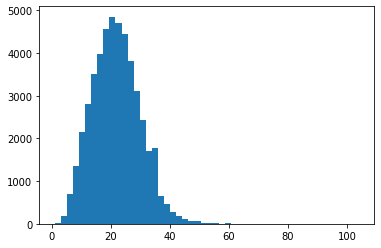

In [ ]:
import matplotlib.pyplot as plt
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [ ]:
import tensorflow as tf
#https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences#add numbers to the sequences to make them all be the same length. 
from tensorflow.keras.utils import to_categorical

max_len = 50
X = [[word_id[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen = max_len, sequences = X, padding='post', value=number_of_words-1)
y = [[tag_id[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen = max_len, sequences = y, padding = 'post', value = tag_id['O'])
y = [to_categorical(i, num_classes=number_of_tags) for i in y]

In [ ]:
y[1]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

####Splitting data into train/test

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

####Build and compile a Bidirectional LSTM model

In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [ ]:
input_word = Input(shape=(max_len, ))
model = Embedding(input_dim = number_of_words, output_dim = max_len, input_length = max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(number_of_tags, activation='softmax'))(model)
model = Model(input_word, out)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 50, 50)            1758900   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 50, 50)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_4 (Bidirectio  (None, 50, 200)          120800    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 50, 200)          240800    
 nal)                                                            
                                                           

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tensorflow.keras.callbacks import  EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

####Training our Model

In [ ]:
#PlotLossesCallback(),
import numpy as np
early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, verbose=0, mode='max', restore_best_weights=False)
callbacks = [early_stopping]

history = model.fit(
    x_train, np.array(y_train),
    validation_split=0.2,
    batch_size = 32,
    epochs = 2,
    verbose = 1,
    callbacks = callbacks
)

Epoch 1/2
840/840 [==============================] - 455s 532ms/step - loss: 0.2014 - accuracy: 0.9530 - val_loss: 0.0892 - val_accuracy: 0.9733
Epoch 2/2
840/840 [==============================] - 437s 520ms/step - loss: 0.0625 - accuracy: 0.9815 - val_loss: 0.0555 - val_accuracy: 0.9839


###Model Evaluation

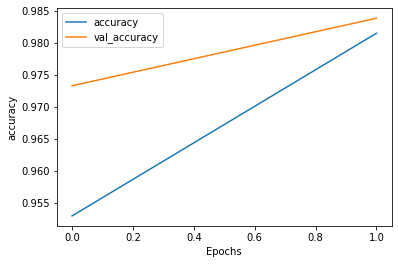

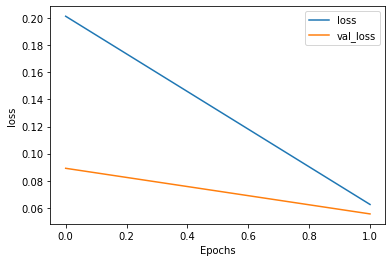

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss");

In [ ]:
model.evaluate(x_test, np.array(y_test))

450/450 [==============================] - 25s 55ms/step - loss: 0.0586 - accuracy: 0.9834


[0.05864374339580536, 0.9834292531013489]

###Test of test set

In [ ]:
y_pred=model.predict(x_test)

450/450 [==============================] - 22s 48ms/step


In [ ]:
num_s, num_w, num_tag = y_pred.shape

y_pred_converted = []
for i in range(num_s):
  word_ = []
  for j in range(num_w):
    tag_ = [0]*num_tag
    ind_max = np.argmax(y_pred[i][j])
    tag_[ind_max] = 1
    word_.append(tag_)
  y_pred_converted.append(word_)

y_pred_converted = np.array(y_pred_converted)

In [ ]:
y_pred_converted[1]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,

In [ ]:
from sklearn.metrics import classification_report
y_test_ch = np.reshape(np.argmax(y_test, 2), (num_s*num_w))
y_pred_converted_ch = np.reshape(np.argmax(y_pred_converted, 2), (num_s*num_w))
print(classification_report(y_test_ch , y_pred_converted_ch))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       101
           1       0.00      0.00      0.00        62
           2       0.90      0.84      0.87      6118
           3       0.80      0.77      0.79      5052
           4       0.77      0.90      0.83      5093
           5       0.87      0.84      0.86     11090
           6       0.00      0.00      0.00       113
           7       0.00      0.00      0.00       128
           8       0.00      0.00      0.00        17
           9       0.99      1.00      1.00    671658
          10       0.00      0.00      0.00        60
          11       0.76      0.66      0.71      5952
          12       0.00      0.00      0.00       140
          13       0.85      0.61      0.71      1950
          14       0.93      0.92      0.93      4755
          15       0.84      0.64      0.72      4917
          16       0.83      0.68      0.75      2194

    accuracy              

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Testing the model Not applicable for this milestone (for future extension) 

In [ ]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]

print('{:15}{:5}\t {}\n'.format('Word', 'True', 'Pred'))
print('-'*30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print('{:15}{}\t{}'.format(words[w-1], tags[true], tags[pred]))

1/1 [==============================] - 0s 59ms/step
Word           True 	 Pred

------------------------------


NameError: ignored

https://towardsdatascience.com/named-entity-recognition-and-classification-with-scikit-learn-f05372f07ba2